In [16]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import math

In [17]:

dates = pd.read_csv('data/dates.csv')
dates = pd.to_datetime(dates['date']).dt.date.values

nlsdf = pd.read_csv('data/NLSdf.csv')
nlsdf['datetime'] = pd.to_datetime(nlsdf['datetime'])
nlsdf


,datetime,dN[cm],dE[cm],dNE[cm],HDOP,Sigma NE,Sigma N,Sigma E,asema
0,2019-01-16 06:10:00,21.500000,23.500000,31.800000,0.4,NaN,NaN,NaN,pasila
1,2019-01-16 06:30:00,12.000000,28.000000,30.500000,0.4,NaN,NaN,NaN,pasila
2,2019-01-16 06:45:00,33.200000,14.400000,36.200000,0.4,NaN,NaN,NaN,pasila
3,2019-01-16 06:50:00,37.700000,2.600000,37.800000,0.4,NaN,NaN,NaN,pasila
4,2019-01-16 06:55:00,35.000000,-1.225000,35.100000,0.4,NaN,NaN,NaN,pasila
...,...,...,...,...,...,...,...,...,...
28102,2023-05-07 15:50:00,-0.050000,-0.525000,0.550000,0.5,0.272500,0.240000,0.120000,joensuu
28103,2023-05-07 15:55:00,1.333333,-0.700000,1.466667,0.5,0.206667,0.170000,0.116667,pasila
28104,2023-05-07 15:55:00,0.100000,-0.433333,0.600000,0.5,0.326667,0.303333,0.110000,joensuu
28105,2023-05-07 16:00:00,1.475000,-0.450000,1.525000,0.5,0.245000,0.215000,0.117500,pasila


In [18]:
clusters = pd.read_csv('data/clusterdf.csv', sep=',')
clusters['dates'] = pd.to_datetime(clusters['dates'])

finaldf = pd.merge(nlsdf, clusters, how='inner', left_on=nlsdf['datetime'].dt.date, right_on=clusters['dates'].dt.date)
finaldf = finaldf.drop(columns=['key_0', 'dates'])
finaldf[list(clusters.columns[1:])] = finaldf[list(clusters.columns[1:])].astype('category')
finaldf

,datetime,dN[cm],dE[cm],dNE[cm],HDOP,Sigma NE,Sigma N,Sigma E,asema,k2,...,k4,k5,k6,k7,k8,k9,k10,k15,k25,k30
0,2019-01-16 06:10:00,21.500000,23.500000,31.800000,0.4,NaN,NaN,NaN,pasila,1,...,0,0,1,1,6,1,1,2,1,23
1,2019-01-16 06:30:00,12.000000,28.000000,30.500000,0.4,NaN,NaN,NaN,pasila,1,...,0,0,1,1,6,1,1,2,1,23
2,2019-01-16 06:45:00,33.200000,14.400000,36.200000,0.4,NaN,NaN,NaN,pasila,1,...,0,0,1,1,6,1,1,2,1,23
3,2019-01-16 06:50:00,37.700000,2.600000,37.800000,0.4,NaN,NaN,NaN,pasila,1,...,0,0,1,1,6,1,1,2,1,23
4,2019-01-16 06:55:00,35.000000,-1.225000,35.100000,0.4,NaN,NaN,NaN,pasila,1,...,0,0,1,1,6,1,1,2,1,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28102,2023-05-07 15:50:00,-0.050000,-0.525000,0.550000,0.5,0.272500,0.240000,0.120000,joensuu,0,...,3,0,3,0,1,8,3,11,8,29
28103,2023-05-07 15:55:00,1.333333,-0.700000,1.466667,0.5,0.206667,0.170000,0.116667,pasila,0,...,3,0,3,0,1,8,3,11,8,29
28104,2023-05-07 15:55:00,0.100000,-0.433333,0.600000,0.5,0.326667,0.303333,0.110000,joensuu,0,...,3,0,3,0,1,8,3,11,8,29
28105,2023-05-07 16:00:00,1.475000,-0.450000,1.525000,0.5,0.245000,0.215000,0.117500,pasila,0,...,3,0,3,0,1,8,3,11,8,29


In [19]:
finaldf['date'] = finaldf['datetime'].dt.date

def select_station(group):
    counts = group['asema'].value_counts()
    if counts.get('joensuu', 0) > counts.get('pasila', 0):
        return group[group['asema'] == 'joensuu']
    else:
        return group[group['asema'] == 'pasila']

finaldf = finaldf.groupby('date', group_keys=False).apply(select_station)
finaldf['dNE_std'] = finaldf.groupby('date')['dNE[cm]'].transform('std')
finaldf['dNE_med'] = finaldf.groupby('date')['dNE[cm]'].transform('median')
finaldf.drop(columns=['date'])

C:\Users\Maria\AppData\Local\Temp\ipykernel_1428\3691941409.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  finaldf = finaldf.groupby('date', group_keys=False).apply(select_station)


,datetime,dN[cm],dE[cm],dNE[cm],HDOP,Sigma NE,Sigma N,Sigma E,asema,k2,...,k6,k7,k8,k9,k10,k15,k25,k30,dNE_std,dNE_med
0,2019-01-16 06:10:00,21.500000,23.500000,31.800000,0.4,NaN,NaN,NaN,pasila,1,...,1,1,6,1,1,2,1,23,31.563175,62.550000
1,2019-01-16 06:30:00,12.000000,28.000000,30.500000,0.4,NaN,NaN,NaN,pasila,1,...,1,1,6,1,1,2,1,23,31.563175,62.550000
2,2019-01-16 06:45:00,33.200000,14.400000,36.200000,0.4,NaN,NaN,NaN,pasila,1,...,1,1,6,1,1,2,1,23,31.563175,62.550000
3,2019-01-16 06:50:00,37.700000,2.600000,37.800000,0.4,NaN,NaN,NaN,pasila,1,...,1,1,6,1,1,2,1,23,31.563175,62.550000
4,2019-01-16 06:55:00,35.000000,-1.225000,35.100000,0.4,NaN,NaN,NaN,pasila,1,...,1,1,6,1,1,2,1,23,31.563175,62.550000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28097,2023-05-07 15:40:00,1.025000,-0.400000,1.075000,0.5,0.230000,0.162500,0.157500,pasila,0,...,3,0,1,8,3,11,8,29,0.871178,0.933333
28100,2023-05-07 15:45:00,1.266667,-0.100000,1.300000,0.5,0.266667,0.230000,0.126667,pasila,0,...,3,0,1,8,3,11,8,29,0.871178,0.933333
28101,2023-05-07 15:50:00,0.800000,-0.633333,1.033333,0.5,0.236667,0.186667,0.146667,pasila,0,...,3,0,1,8,3,11,8,29,0.871178,0.933333
28103,2023-05-07 15:55:00,1.333333,-0.700000,1.466667,0.5,0.206667,0.170000,0.116667,pasila,0,...,3,0,1,8,3,11,8,29,0.871178,0.933333


In [20]:
filtdf = finaldf[(finaldf['dNE[cm]'] > 40)]
print(len(filtdf)/len(finaldf)*100, '%', len(filtdf), len(finaldf))

hairiot = list(filtdf['datetime'].dt.date.unique())
print(len(hairiot)/len(clusters)*100, '%', len(hairiot))

6.632562012967699 % 1115 16811
25.179856115107913 % 35


In [21]:
# bin_edges = pd.cut(finaldf['dNE[cm]'], bins=10, retbins=True)[1]
# print(bin_edges[1])

filtdf = finaldf[(finaldf['dNE[cm]'] > 40) & (finaldf['dNE_med'] < 2)]#bin_edges[1]]
print(len(filtdf)/len(finaldf)*100, '%')

hairiot = list(filtdf['datetime'].dt.date.unique())
print(len(hairiot)/len(clusters)*100, '%')

0.6067455832490631 %
10.79136690647482 %


In [22]:
# bin_edges = pd.cut(finaldf['dNE_med'], bins=10, retbins=True)[1]
# print(bin_edges[1])
# filtdf = finaldf[finaldf['dNE_med'] < 2]#bin_edges[1]]
# print(len(filtdf)/len(finaldf)*100, '%')

# hairiot = list(filtdf['datetime'].dt.date.unique())
# print(len(hairiot)/len(clusters)*100, '%')

In [23]:
#finaldf.loc[finaldf['datetime'].dt.date == dt.date(2019,8,20)]

In [24]:

# # Convert 'asema' to categorical codes for coloring
# filtdf['asema_code'] = filtdf['asema'].astype('category').cat.codes

# # Create scatter plot
# plt.figure(figsize=(10, 6))
# scatter = plt.scatter(
#     filtdf['datetime'],
#     filtdf['dNE[cm]'],
#     alpha=0.7,
#     c=filtdf['asema_code'],
#     cmap='tab10'
# )

# # Create legend using unique 'asema' values
# handles, _ = scatter.legend_elements(prop="colors", alpha=0.9)
# labels = filtdf['asema'].astype('category').cat.categories
# plt.legend(handles, labels, title="asema")

# # Label axes and show plot
# plt.xlabel('Datetime')
# plt.ylabel('dNE[cm]')
# plt.title('Scatter Plot of dNE[cm] over Time by Station')
# plt.tight_layout()
# plt.show()


In [25]:
clusters['hairio'] = clusters['dates'].dt.date.isin(hairiot)
finaldf['hairio'] = finaldf['datetime'].dt.date.isin(hairiot)
paivat = clusters['dates'].dt.date
neghairiot = list(clusters.loc[~clusters['hairio']]['dates'].dt.date)

In [26]:
i=0

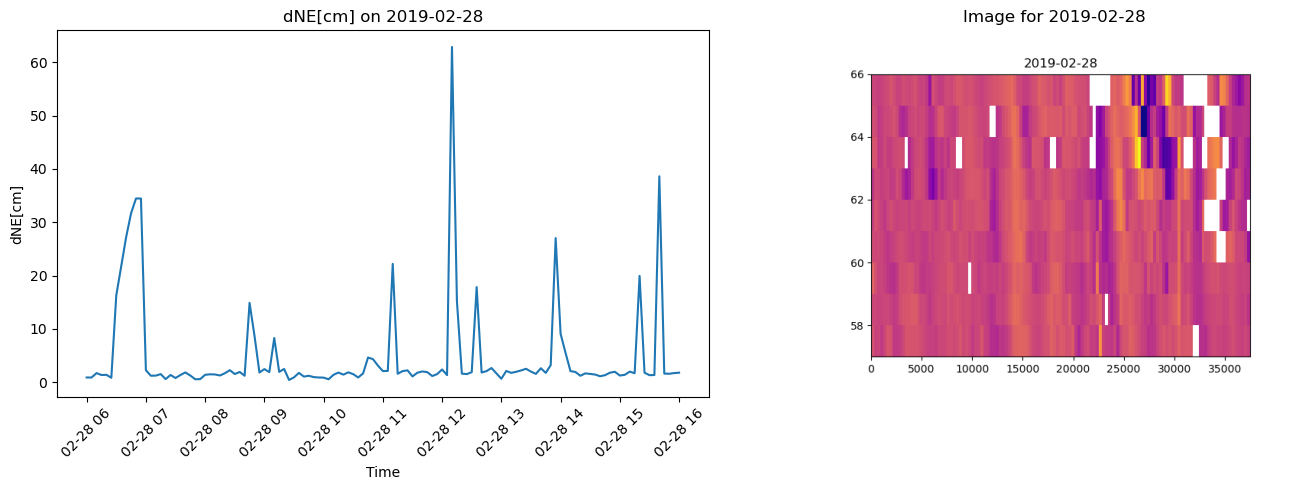

1 / 15 2019-02-28


In [27]:
anomaly_day = hairiot[i]

# Filter data for that day
day_data = finaldf[finaldf['datetime'].dt.date == anomaly_day]

# Build image path
image_path = f"data/og/{anomaly_day}og.png"

# Create side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot dNE[cm]
axes[0].plot(day_data['datetime'], day_data['dNE[cm]'])
axes[0].set_title(f'dNE[cm] on {anomaly_day}')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('dNE[cm]')
axes[0].tick_params(axis='x', rotation=45)

# Show image if it exists
if os.path.exists(image_path):
    img = mpimg.imread(image_path)
    axes[1].imshow(img)
    axes[1].axis('off')
    axes[1].set_title(f'Image for {anomaly_day}')
else:
    axes[1].text(0.5, 0.5, 'Image not found', ha='center', va='center')
    axes[1].axis('off')

plt.tight_layout()
plt.show()

# Progress print
i += 1
print(i, '/', len(hairiot), hairiot[i-1])

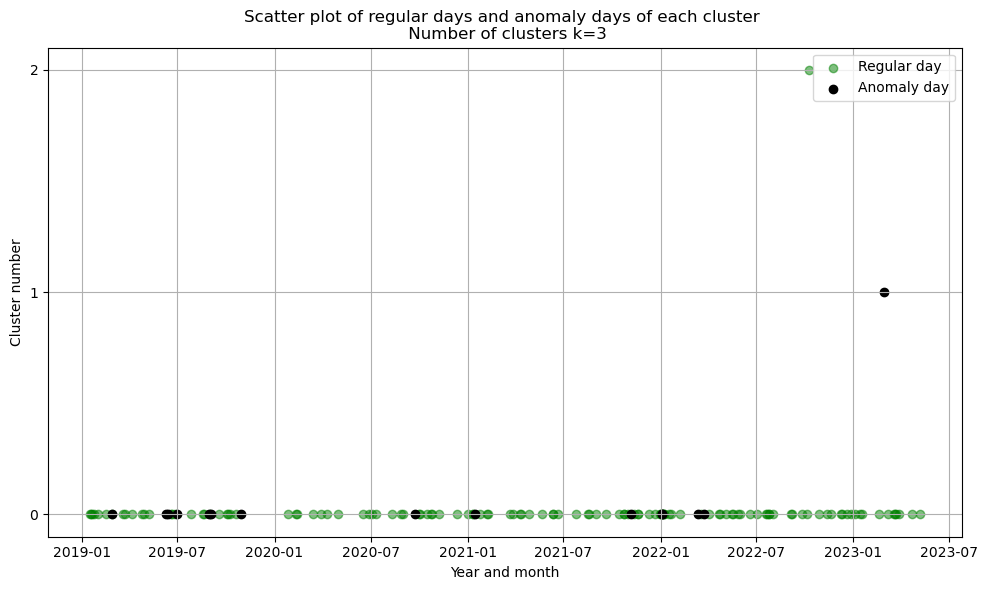

In [28]:
#i=0
ks = [2,3,4,5,6,7,8,9,10,15,25,30]
k=ks[i]
x_col = f'k{k}'

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each group separately to apply different alpha values
for hairio_value, group in clusters.groupby('hairio'):
    ax.scatter(
        group['dates'],
        group[x_col],
        color='black' if hairio_value else 'green',
        alpha=1.0 if hairio_value else 0.5,
        label= f'Anomaly day' if hairio_value else 'Regular day'
    )

# Add grid and legend
ax.grid(True)
ax.legend()


ax.set_yticks(range(0, k))


# Add labels and title
plt.title(f'Scatter plot of regular days and anomaly days of each cluster \n Number of clusters k={k}')
plt.ylabel('Cluster number')
plt.xlabel('Year and month')
plt.tight_layout()
#plt.savefig(f'data/klusteriscatter/klusteriscatter{i}.png')
plt.show()

i+=1


In [29]:
clusdict={
    'k2': [1,0],
    'k4': [0,3],
    'k6': [1,3],
    'k7': [1,0],
    'k8': [6,1],
    'k9': [1,8],
    'k10': [1,3],
    'k25': [1,24],
    'k30': [23,14]
    }

K=k30, Cluster 14: 13 heatmaps


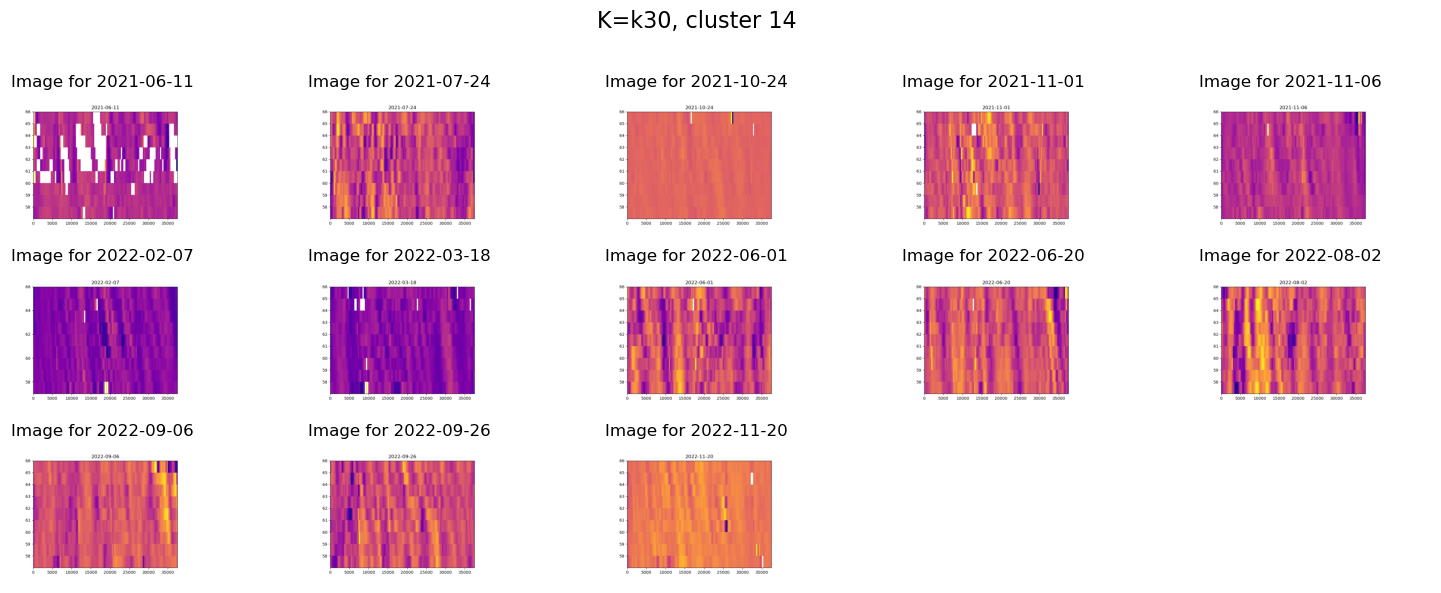

In [51]:
#a=0

asd=list(clusdict.keys())[a]

klabel = clusdict[asd][1]

kdates = np.where(clusters[asd].values == klabel)[0]
n_images = len(kdates)
print(f"K={asd}, Cluster {klabel}: {n_images} heatmaps")

n_cols = 5
n_rows = math.ceil(n_images / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 2*n_rows))
axes = axes.flatten()

for axj, idx in enumerate(kdates):
    kdate = clusters['dates'][idx].date()
    image_path = f"data/og/{kdate}og.png"
    
    if os.path.exists(image_path):
        ax = axes[axj]
        img = mpimg.imread(image_path)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'Image for {kdate}')

    else:
        ax.text(0.5, 0.5, 'Image not found', ha='center', va='center')
        ax.axis('off')

for kj in range(axj+1, len(axes)):
    axes[kj].axis('off')

fig.suptitle(f'K={asd}, cluster {klabel}', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

a+=1

# for klabel in kvalues:

#     kdates = np.where(clusters['k2'].values == klabel)[0]
#     n_images = len(kdates)
#     print(f"Cluster {klabel}: {n_images} heatmaps")

#     n_cols = 5
#     n_rows = math.ceil(n_images / n_cols)
#     fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 2*n_rows))
#     axes = axes.flatten()

#     for axj, idx in enumerate(kdates):
#         kdate = clusters['dates'][idx].date()
#         image_path = f"data/og/{kdate}og.png"
        
#         if os.path.exists(image_path):
#             ax = axes[axj]
#             img = mpimg.imread(image_path)
#             ax.imshow(img)
#             ax.axis('off')
#             ax.set_title(f'Image for {anomaly_day}')

#         else:
#             ax.text(0.5, 0.5, 'Image not found', ha='center', va='center')
#             ax.axis('off')

#     for kj in range(axj+1, len(axes)):
#         axes[kj].axis('off')

#     fig.suptitle(f'Cluster {klabel}', fontsize=16)
#     fig.tight_layout(rect=[0, 0, 1, 0.96])
#     plt.show()
